In [1]:
# Install pyspark

!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=392e1b90f06dfadda0110c69ae9b8a33ca175bb08e8888eda1cd1ffca730b63e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [ ]:
# Install geographiclib

!pip install geographiclib

In [6]:
# Import libraries

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tqdm
import psutil
import time
import math
from math import radians
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise
from geographiclib.geodesic import Geodesic

from google.colab import drive

In [ ]:
# Create spark session
spark = SparkSession.builder.getOrCreate()

# Create spark context
sc = spark.sparkContext

# Check how much memory is allocated to spark runtime
mem_info = psutil.virtual_memory()
total_memory_gb = mem_info.total / (1024 * 1024 * 1024)
print("Total Memory Allocated to Spark Runtime:", int(total_memory_gb), "GB")

In [7]:
# Mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load data
folder = '/content/drive/MyDrive/Colab Notebooks/cse 547 - PROJECT/'
name = '202309-citibike-tripdata_4.csv'
path = folder + name

sep23_data = spark.read.csv(path, sep = ',', header = True, inferSchema = True)

In [9]:
# Choose which data-set
data = sep23_data

# View data
print(f"NUM DATA POINTS = {data.count()}")
data.show()

NUM DATA POINTS = 575162
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|         start_lat|         start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|E7CE7CE80519EB26| classic_bike|2023-09-16 17:15:28|2023-09-16 17:19:00|Halsey St & Ralph...|         4334.02|Broadway & Madiso...|       4483.10|          40.68494|         -73.92299|         40.68822|         -73.91966|       member|
|56F4C65B769CF128| classic_bike

In [10]:
# Project only relevant columns
projected_data = data.select("started_at", "ended_at", "start_lat", "start_lng",
                  "end_lat", "end_lng")

# Select a small sample (first N) of rows
N = 1000
small_data = projected_data.select("*").limit(N)
small_data.show()

+-------------------+-------------------+------------------+------------------+-----------------+------------------+
|         started_at|           ended_at|         start_lat|         start_lng|          end_lat|           end_lng|
+-------------------+-------------------+------------------+------------------+-----------------+------------------+
|2023-09-16 17:15:28|2023-09-16 17:19:00|          40.68494|         -73.92299|         40.68822|         -73.91966|
|2023-09-03 21:45:29|2023-09-03 21:53:33|       40.73240447|     -73.998393893|        40.722055|        -73.989111|
|2023-09-06 11:59:58|2023-09-06 12:23:02| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|
|2023-09-20 09:09:07|2023-09-20 09:14:27|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|
|2023-09-06 20:34:25|2023-09-06 20:41:56| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|
|2023-09-06 21:14:06|2023-09-06 21:36:29| 40.78232260730881|-73.

In [11]:
# Function to process start and end times of day into pure seconds

def extract_times_to_seconds(rdd):


    # Split started_at and ended_at columns into date and time
    rdd = rdd.withColumn("start_date", split(col("started_at"), " ")[0]) \
          .withColumn("start_time", split(col("started_at"), " ")[1]) \
          .withColumn("end_date", split(col("ended_at"), " ")[0]) \
          .withColumn("end_time", split(col("ended_at"), " ")[1])


    # Drop the original started_at and ended_at columns
    rdd = rdd.drop("started_at", "ended_at")


    # Split the time strings into hours, minutes, and seconds
    rdd = rdd.withColumn("start_time_split", split(col("start_time"), ":")) \
          .withColumn("end_time_split", split(col("end_time"), ":"))


    # Convert hours, minutes, seconds to seconds
    rdd = rdd.withColumn("start_seconds",
                      col("start_time_split")[0].cast("int") * 3600 +
                      col("start_time_split")[1].cast("int") * 60 +
                      col("start_time_split")[2].cast("int")) \
          .withColumn("end_seconds",
                      col("end_time_split")[0].cast("int") * 3600 +
                      col("end_time_split")[1].cast("int") * 60 +
                      col("end_time_split")[2].cast("int"))


    # Drop intermediate columns
    rdd = rdd.drop("start_time_split", "end_time_split")


    # Drop all date and time columns EXCEPT for the new 'seconds' columns
    rdd = rdd.drop("start_date", "start_time", "end_date", "end_time")


    # Optionally also drop the 'end_seconds' column to focus on 'start_seconds'
    rdd = rdd.drop("end_seconds")



    return rdd


# Test function
test = extract_times_to_seconds(small_data)
test.show()

+------------------+------------------+-----------------+------------------+-------------+
|         start_lat|         start_lng|          end_lat|           end_lng|start_seconds|
+------------------+------------------+-----------------+------------------+-------------+
|          40.68494|         -73.92299|         40.68822|         -73.91966|        62128|
|       40.73240447|     -73.998393893|        40.722055|        -73.989111|        78329|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        43198|
|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|        32947|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        74065|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        76446|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        59327|
|      40.672714114|     -73.954153895|         40.66846|          -73.9282|        29888|

In [12]:
##
# Functions to calculate our spatio-temporal distance metric
#

# Note: all column indices are hard-coded


##
# Function to get bearing (in radians) between two points on Earth's surface
#

def get_bearing(lat1, lon1, lat2, lon2):
    brng = Geodesic.WGS84.Inverse(lat1, lon1, lat2, lon2)['azi1']
    return radians(brng)


##
# Calculate the absolute value of the sine of the difference in initial bearings
# between two trips

def sine_bearings(trip1, trip2):

    trip1_bearing = get_bearing(trip1[0], trip1[1], trip1[2], trip1[3])
    trip2_bearing = get_bearing(trip2[0], trip2[1], trip2[2], trip2[3])

    return np.abs(np.sin(trip1_bearing - trip2_bearing))


##
# Calculate the great circle distance between two points on Earth's surface
#

def great_circle(point1, point2):

    A = [radians(_) for _ in point1]
    B = [radians(_) for _ in point2]

    AtoB = haversine_distances([A], [B])

    return 6371 * AtoB[0][0]


##
# Combine everything into one distance metric
#

def custom_distance_metric(x_row, c_row, lam, gam):

    ##
    # time
    #
    s = 24 * 60 * 60

    start_time_difference = np.abs(x_row[4] - c_row[4])

    dist = lam * np.min([start_time_difference, s - start_time_difference])


    ##
    # space
    #

    # Great circle distance between start points
    dist += great_circle(x_row[:2], c_row[:2])

    # Great circle distance between end points
    dist += great_circle(x_row[2:4], c_row[2:4])

    # Penalize large angle (difference in bearings) between trip vectors
    dist += gam * sine_bearings(x_row[:4], c_row[:4])


    return dist



##
# Alternative version of our distance metric using planar approximations
# (ignoring Earth's curvature)

def custom_distance_metric_euclid(x_row, c_row, lam, gam):

    ##
    # time
    #
    s = 24 * 60 * 60 # number of seconds in a day

    start_time_difference = np.abs(x_row[4] - c_row[4])

    dist = lam * np.min([start_time_difference, s - start_time_difference]) / (0.5 * s)
    # print(f"Time cost = {dist}")


    ##
    # space (planar approx)
    #

    # Euclidean distance between start points
    d1 = np.linalg.norm(x_row[:2] - c_row[:2], 2)
    # print(f"Distance between start points = {d1}")
    dist += d1

    # Euclidean distance between end points
    d2 = np.linalg.norm(x_row[2:4] - c_row[2:4], 2)
    # print(f"Distance between end points = {d2}")
    dist += d2

    # Penalize large angle (in the plane) between trip vectors
    a = x_row[2:4] - x_row[:2] # trip vector 1
    b = c_row[2:4] - c_row[:2] # trip vector 2

    sine = np.cross(a, b) / (np.linalg.norm(a, 2) * np.linalg.norm(b, 2))
    p = gam * np.abs(sine)
    # print(f"Angular penalty = {p}")
    dist += p



    return dist


In [13]:
##
# K-means algorithm
#

def K_means_time_and_space(data_arr, centroid_arr, MAX_ITER, lam, gam):

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)

    # outer-most loop for k-means iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

        # will store the count of the number of points falling into each
        # cluster
        point_count = np.zeros([centroid_arr.shape[0], 1])



        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the custom distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])



            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # get the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i]

              # calculate the distance from the current row to the centroid
              # dists[i] = custom_distance_metric(x_row, c_row, lam, gam)
              dists[i] = custom_distance_metric_euclid(x_row, c_row, lam, gam)



            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # add the current x_row to the row in the array of new centroids
            # corresponding to the cluster x_row falls into
            new_centroids[int(clusters[j]), :] += x_row
            point_count[int(clusters[j])] += 1

            # store the cost(s) associated with the current x_row
            costs[t] += dists[int(clusters[j])]

        # print cost at the end of this iteration
        print(f"After {t + 1} iterations, cost = {costs[t]}")


        # divide by the number of points in each cluster to obtain the new
        # centroids
        new_centroids = new_centroids / point_count
        centroid_arr = new_centroids


    # return the costs, new centroids, and cluster assignments
    return costs, new_centroids, clusters

In [14]:
##
# Prepare to run K-means
#

# Collect working data-set into an array
small_time_and_space = extract_times_to_seconds(small_data)
small_time_and_space_arr = np.array(small_time_and_space.collect())

# Set hyper-parameters
k = 5
lam = 1e-10
gam = 1e-10

# Pick the first k points as a "random" initialization of centroids
random_centroids = small_time_and_space_arr[:k]

print(small_time_and_space_arr.shape)
print(random_centroids.shape)

(1000, 5)
(5, 5)


In [15]:
##
# Run K-means
costs, centroids, clustering = K_means_time_and_space(small_time_and_space_arr,
                                                      random_centroids,
                                                      MAX_ITER = 20,
                                                      lam = lam,
                                                      gam = gam)

After 1 iterations, cost = 54.01808792429585
After 2 iterations, cost = 47.37953186698189
After 3 iterations, cost = 41.54282947282771
After 4 iterations, cost = 40.66336015165235
After 5 iterations, cost = 40.49256257819944
After 6 iterations, cost = 40.4087219957554
After 7 iterations, cost = 40.40508773731467
After 8 iterations, cost = 40.356433500075454
After 9 iterations, cost = 40.31915803574669
After 10 iterations, cost = 40.31361593638315
After 11 iterations, cost = 40.31361593638315
After 12 iterations, cost = 40.31361593638315
After 13 iterations, cost = 40.31361593638315
After 14 iterations, cost = 40.31361593638315
After 15 iterations, cost = 40.31361593638315
After 16 iterations, cost = 40.31361593638315
After 17 iterations, cost = 40.31361593638315
After 18 iterations, cost = 40.31361593638315
After 19 iterations, cost = 40.31361593638315
After 20 iterations, cost = 40.31361593638315


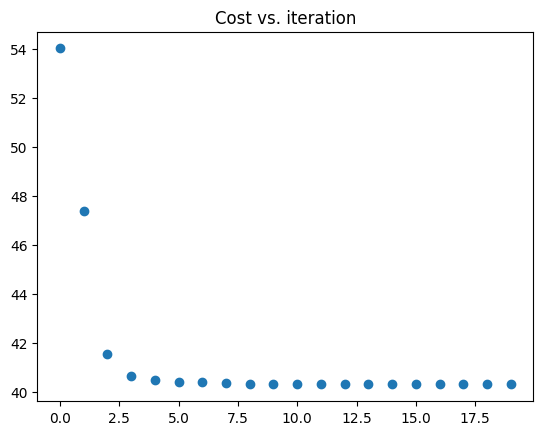

In [16]:
##
# Plot cost vs. iteration
#

iterations = np.arange(costs.shape[0])
plt.scatter(iterations, costs)
plt.title("Cost vs. iteration")
plt.show()

<ipython-input-17-79c8faea4303>:33: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 11;


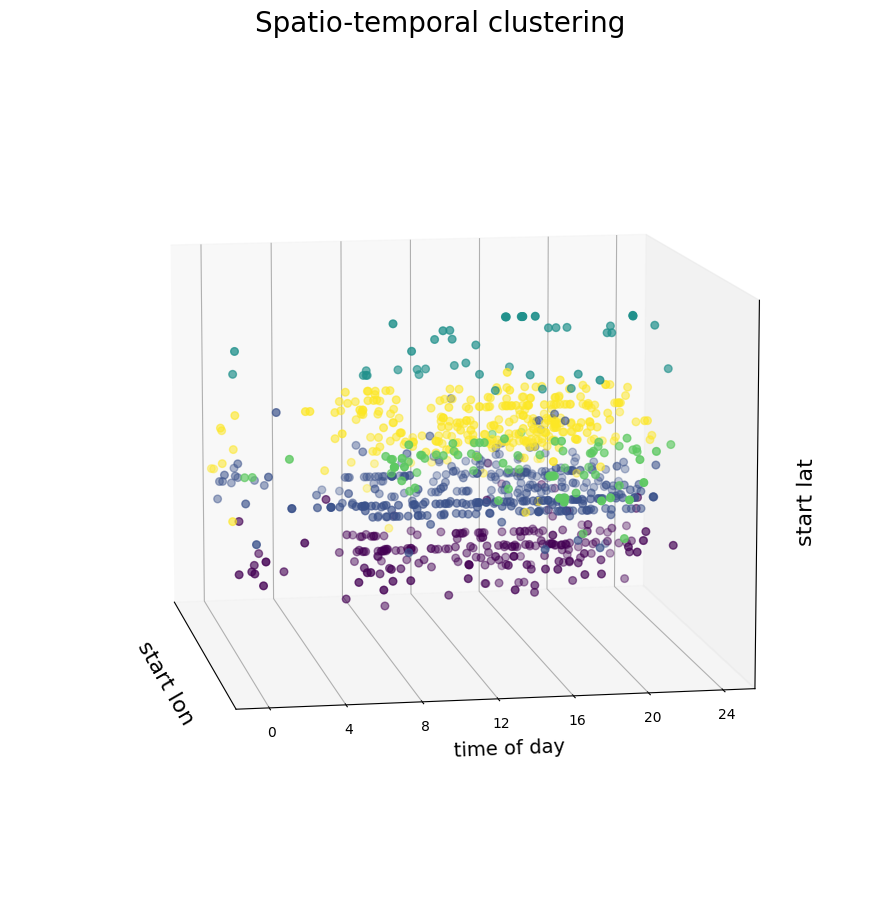

In [17]:
##
# Visualize clusters in 3D
#

from mpl_toolkits.mplot3d import Axes3D


start_lons = small_time_and_space_arr[:, 1]
start_lats = small_time_and_space_arr[:, 0]
start_times = small_time_and_space_arr[:, 4] / 3600




fig = plt.figure(figsize = (10, 15))
ax = plt.axes(projection='3d')
fig.tight_layout(pad = 5.0)

ax.scatter(start_lons, start_times, start_lats, c = clustering, cmap = 'viridis', s = 30);

ax.set_xticks([]);
ax.set_zticks([]);
ax.set_yticks(np.linspace(0, 24, 7));

title = ax.set_title("Spatio-temporal clustering", fontsize = 20);
ax.set_xlabel("start lon", fontsize = 16);
ax.set_zlabel("start lat", fontsize = 16);
ax.set_ylabel("\n time of day", fontsize = 14);
title.set_position([0.5, 1]);


ax.view_init(10, -10, 0);
ax.dist = 11;